<font color="#de3023"><h1><b>REMINDER: MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Debiasing Word Embeddings for Emotions

*Adapted from https://github.com/panchambanerjee/Word_embedding_biases*

A new AI for Mental Health startup has reached out to us AI scholars for help with their model. Based on text data from a psychological interview describing their commonly felt emotions and a variety of other data points, this startup helps to diagnose and prescribe treatment. However, they have noticed that the Natural Language Processing (NLP) model that they use have embeddings that may be biased, and are worried that this might affect the accuracy of their predictions. Let's see what we can do to help this startup! 

In this notebook, we will:
* Explore and understand how biases enter our word embedding models
* Look at some methods for debiasing our embeddings, and what the tradeoffs for debiasing might be.
* Explore a package, AllenNLP, that has a few bias mitigator functions and metrics built-in.

**DISCLAIMER: We are going to reference a conventional binary understanding of gender in this notebook for solely for the purposes of understanding how biases in natural language can emerge. We recognize and acknowledge that a binary understanding of gender is not the only one that exists.*


In [ ]:
#@title Run to load data and helper functions
!pip install spacy==2.2.2
!pip install allennlp
!python -m spacy download en_core_web_md

import spacy
import numpy as np
import pandas as pd
import en_core_web_md
nlp = en_core_web_md.load()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
import allennlp.fairness.bias_metrics as af
import allennlp.fairness.bias_mitigators as afb

def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

def get_vector(w):
    return nlp(w).vector


def neutralize(word, g, model):
    
    e = get_vector(word)
    e_biascomponent = np.dot(e, g)/(np.linalg.norm(g)**2) *g
    e_debiased = e - e_biascomponent
 
    return e_debiased

def equalize(pair, bias_axis, model):
    
    w1, w2 = pair
    e_w1, e_w2 = get_vector(w1), get_vector(w2)
    
    mu = (e_w1 + e_w2)/2

    mu_B = np.dot(mu, bias_axis)/np.linalg.norm(bias_axis)**2 * bias_axis
    mu_orth = mu - mu_B

    e_w1B = np.dot(e_w1, bias_axis)/np.linalg.norm(bias_axis)**2 * bias_axis
    e_w2B = np.dot(e_w2, bias_axis)/np.linalg.norm(bias_axis)**2 * bias_axis
        
    corrected_e_w1B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth)**2))*(e_w1B - mu_B)\
    /np.linalg.norm(e_w1 - mu_orth - mu_B)
    corrected_e_w2B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth)**2))*(e_w2B - mu_B)\
    /np.linalg.norm(e_w2 - mu_orth - mu_B)

    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2

    # Reduce the 300-dimensional data to 2D for plotting purposes
def plot_2d(words, word_vectors): 
    
    pca = PCA(n_components = 2)
    pca.fit(word_vectors)
    
    word_vecs_2d = pca.transform(word_vectors)
    
    plt.figure(figsize=(10,10))

    plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1],color='r',marker='o',alpha=.5)

    for word, coord in zip(words, word_vecs_2d):
        x, y = coord
        plt.text(x, y, word, size = 10)

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Revisiting Word Embeddings

Word-embeddings are representations of words as a vector, where each number in that vector represents the similarity of that word to a particular "concept" (which in practice, is learned by association with a cluster of other words).

![](https://cdn-images-1.medium.com/max/1600/1*mLrheV1nGz7XemDAVRcZ4A.png) 

This means that word-embeddings have some pretty cool properities, like how moving along a certain "direction" can represent an intuitive change in the meaning of a word. In this example, we are concerned about movements along the "gender" direction. In the image below, we see that moving along the "gender" direction from man ---> woman, can also give us an analogical movement from king ---> queen.

![](https://miro.medium.com/max/3496/1*SyY1GT1GvKifzpyLc18YEg.png) 

We can visualize word-embeddings, which are usually very high-dimensional, with a dimensionality reduction technique called Principal Components Analysis. This helps us to visualize similarities between words by clustering them together on a 2D plane. **Can you define an array to store the vectors for the words below, and add on to the list of the words to see if you can find similar/different clusters to the ones that already exist?**


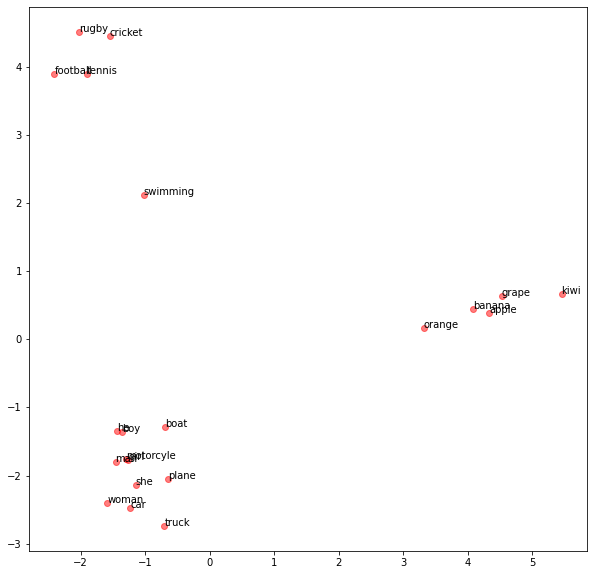

In [ ]:
words = ['car','truck','plane','boat','motorcyle','apple','orange','banana','grape','kiwi',\
        'man','woman','he','she','girl','boy','football','cricket','rugby','tennis','swimming']

def get_vector_list(words):
  ## YOUR CODE HERE: Use the "get_vector()" function to transform individual words into their pre-trained embeddings.
  word_vectors = []
    ## hint do a for-loop here
  for word in words:
    word_vectors.append(get_vector(word)) 
  return word_vectors

plot_2d(words,get_vector_list(words))


For this notebook, we are going to explore two sets of words. We are going to look at the set of job-related words, which have famously been the topic of NLP Bias research starting with this paper: https://arxiv.org/pdf/1607.06520.pdf. **What do you notice about how these words are clustered?**

['maestro', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'fighter', 'pilot', 'boss', 'executive', 'CEO', 'banker', 'programmer', 'homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'designer', 'counselor']


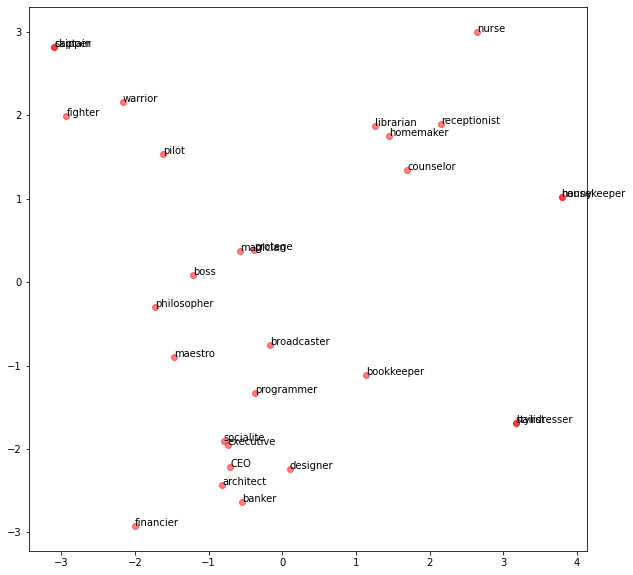

In [ ]:
mjobs = ["maestro", "skipper", "protege", "philosopher", "captain", "architect", "financier", "warrior", 
        "broadcaster", "magician", "fighter", "pilot", "boss", "executive", "CEO", "banker", "programmer"] ## add on a few words!
fjobs = ["homemaker", "nurse", "receptionist", "librarian", "socialite", "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper", "designer", "counselor"] ## add on a few words!
jobs = mjobs+fjobs ## YOUR CODE HERE: concatenate the two lists, please!
print(jobs)
plot_2d(jobs,get_vector_list(jobs))

We are also going to look at emotion words, as they pertain to the task that we have been given. We have given some words here that are conventionally associated with the masculine and feminine, **can you add on to this list? What do you observe about how these emotions are clustered?**

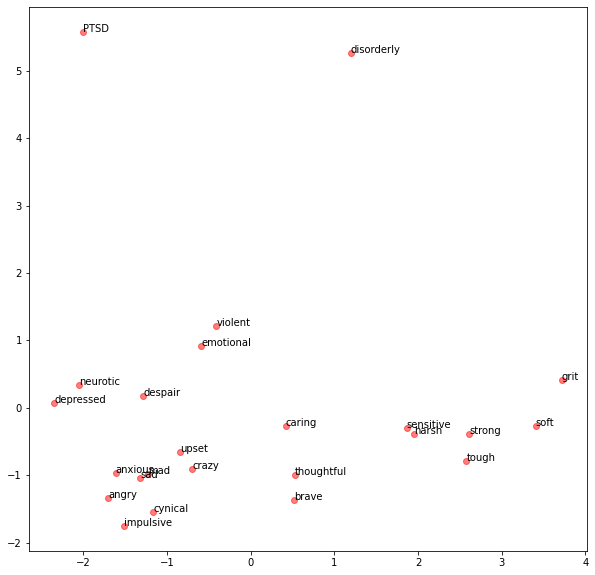

In [ ]:
masc_feelings = ["angry", "tough", "disorderly", "strong", "harsh", "mad", "PTSD", "cynical", "grit", "violent", "brave", "impulsive"]
fem_feelings = ["sensitive", "sad", "depressed", "neurotic", "upset", "despair", "crazy", "emotional", "soft", "anxious", "caring", "thoughtful"]

feelings = masc_feelings+fem_feelings ## YOUR CODE HERE: concatenate the two lists, please!

plot_2d(feelings,get_vector_list(feelings))

# Understanding Bias in Word Embeddings

What is "bias" when it comes to word embeddings? "Bias" amongst human beings can mean an unfair preference for or prejudice against another human being that is not founded on good reasons. It can lead to things like stereotypes that can be generalizations, like "every asian is good at math" or "all germans are tall". 

"Bias" in word embeddings have a more specific meaning. Bias refers to the situation where specific words are unfairly associated with a protected attribute or class, like gender, race or nationality. In other words, it means that specific words have a "gender direction" or a "race direction" in the embedding space that is systematically different from other words in the same class. Depending on how these embeddings are used, it can lead to bias in real human interactions! **Can you think of a few examples of how this can happen?**


![](https://www.researchgate.net/profile/Venkatesh-Saligrama/publication/304163868/figure/fig1/AS:375256100425729@1466479434837/Comparison-of-gender-bias-of-profession-words-across-two-embeddings-word2vec-trained-on.png
) 

We are going to explore bias in word embeddings with jobs, and then try to apply what we learnt to emotions.

               o  He-Score  She-Score Color
0        retired  0.457214   0.360950  blue
1         doctor  0.467547   0.509170  blue
2        teacher  0.443727   0.512202  blue
3        student  0.373731   0.425599  blue
4         miller  0.183405   0.148845  blue
5      assistant  0.400182   0.388268  blue
6         lawyer  0.395774   0.350339  blue
7          baker  0.207723   0.218408  blue
8          judge  0.481602   0.448580  blue
9       governor  0.408087   0.299725  blue
10        butler  0.218866   0.184498  blue
11          chef  0.280673   0.273837  blue
12     homemaker  0.406917   0.579778   red
13         nurse  0.319476   0.513825   red
14  receptionist  0.284964   0.460631   red
15     librarian  0.443727   0.512202   red
16     socialite  0.302637   0.262247   red
17   hairdresser  0.156763   0.249413   red
18         nanny  0.192022   0.331330   red
19    bookkeeper  0.296787   0.267387   red
20       stylist  0.156763   0.249413   red
21   housekeeper  0.192022   0.3

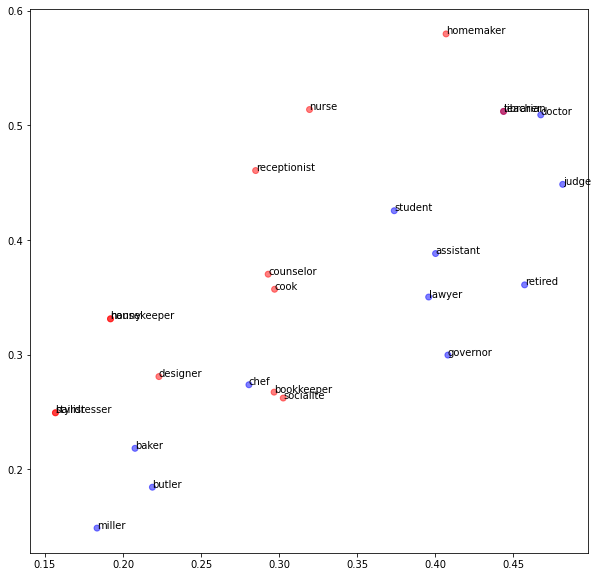

In [ ]:
male_pronoun = nlp(u"he")
female_pronoun = nlp(u"she")

male_jobs = ["retired", "doctor", "teacher", "student", "miller", "assistant", "lawyer", "baker", "judge", "governor", "butler", "chef"] ## add some words here
female_jobs = ["homemaker", "nurse", "receptionist", "librarian", "socialite", "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper", "designer", "counselor", "cook"] ## add some words here

df = pd.DataFrame(columns = ["o", "He-Score", "She-Score", "Color"])

for job in male_jobs:
  he_score = male_pronoun.similarity(nlp(job))
  she_score = female_pronoun.similarity(nlp(job)) ## YOUR CODE HERE calculate the similarity for male associated jobs and the female pronoun
  df = df.append(pd.Series([job, he_score, she_score, "blue"], index=df.columns), ignore_index=True)

## YOUR CODE HERE: Loop through all the female associated jobs, and calculate the associated similarity scores, appending them to df with the color "Red"
for job in female_jobs:
  he_score = male_pronoun.similarity(nlp(job))
  she_score = female_pronoun.similarity(nlp(job)) ## YOUR CODE HERE calculate the similarity for male associated jobs and the female pronoun
  df = df.append(pd.Series([job, he_score, she_score, "red"], index=df.columns), ignore_index=True)

print(df)

plt.figure(figsize=(10,10))

plt.scatter(df['He-Score'], df['She-Score'],color=df['Color'],alpha=.5)

for word, x, y in zip(df['o'], df['He-Score'], df['She-Score']):
    plt.text(x, y, word, size = 10)

As we can see from the graph, the words that are conventionally associated with feminine vocations rank more highly in a similarity score with the female pronoun than the male pronoun. Likewise, the words that are conventionally associated with masculine vocations have the opposite relationship. In general, we can clearly linearly separate these two groups of job words, which implies that there is a bias. **Let's see if we can find a bias in emotion-related words as well.**

             o  He-Score  She-Score Color
0        angry  0.471334   0.449154  blue
1        tough  0.424371   0.356972  blue
2   disorderly  0.234607   0.210559  blue
3       strong  0.453318   0.392404  blue
4        harsh  0.326737   0.314195  blue
5          mad  0.499465   0.470300  blue
6         PTSD -0.032522  -0.004157  blue
7      cynical  0.281132   0.249401  blue
8         grit  0.156974   0.138557  blue
9      violent  0.356446   0.307334  blue
10       brave  0.372961   0.380324  blue
11   impulsive  0.315792   0.312956  blue
12   sensitive  0.223989   0.290173   red
13         sad  0.453681   0.488002   red
14   depressed  0.301057   0.356786   red
15    neurotic  0.179870   0.227386   red
16       upset  0.477443   0.493999   red
17     despair  0.320009   0.330229   red
18       crazy  0.439517   0.467499   red
19   emotional  0.332513   0.406911   red
20        soft  0.284768   0.336005   red
21     anxious  0.394012   0.439069   red
22      caring  0.323118   0.42599

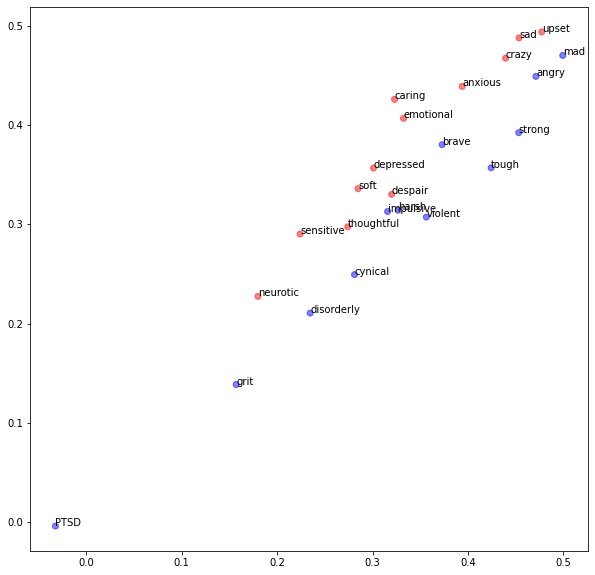

In [ ]:
## YOUR CODE HERE: repeat the experiment for emotion related words
male_pronoun = nlp(u"he")
female_pronoun = nlp(u"she")

df = pd.DataFrame(columns = ["o", "He-Score", "She-Score", "Color"])

for feeling in masc_feelings:
  he_score = male_pronoun.similarity(nlp(feeling))
  she_score = female_pronoun.similarity(nlp(feeling)) ## YOUR CODE HERE calculate the similarity for male associated jobs and the female pronoun
  df = df.append(pd.Series([feeling, he_score, she_score, "blue"], index=df.columns), ignore_index=True)

for feeling in fem_feelings:
  he_score = male_pronoun.similarity(nlp(feeling))
  she_score = female_pronoun.similarity(nlp(feeling)) ## YOUR CODE HERE calculate the similarity for male associated jobs and the female pronoun
  df = df.append(pd.Series([feeling, he_score, she_score, "red"], index=df.columns), ignore_index=True)

print(df)

plt.figure(figsize=(10,10))

plt.scatter(df['He-Score'], df['She-Score'],color=df['Color'],alpha=.5)

for word, x, y in zip(df['o'], df['He-Score'], df['She-Score']):
    plt.text(x, y, word, size = 10)

What do you think? Was there bias in emotion related words? Was there more or less bias? Why do you think this is the case?

## Debiasing Methods

We are going to explore a method of debiasing in depth called "Hard-Debiasing". This is the most naive kind of debiasing, because it's the most "obvious" solution to our problem. This approach can have tradeoffs, such as a lower performance on certain tasks, but it is good to understand for a start.

Hard Debiasing basically means taking that gender "direction" completely out of the embeddings for that word. Recall that word-embeddings are basically a set of numbers, each of which represents a movement in a particular direction. If we can identify the "gender" direction in each word, we can just delete it completely, like in the figure below.

![](https://miro.medium.com/max/700/1*UQrsnmhe8CuVRs8RXVmx7g.png)

For more debiasing techniques, check out this webpage here: https://guide.allennlp.org/fairness#3

Let's compare the similarity of our words to this "gender" direction before and after debiasing, and let's also look at the plots that we did above before and after debiasing. **What do you think? Did we get rid of the bias?**

In [ ]:
# g = (
#     (get_vector('woman')-get_vector('man')) + 
#     (get_vector('she') - get_vector('he')) +
#     (get_vector('mother') - get_vector('father')) +
#     (get_vector('girl') - get_vector('boy')) +
#     (get_vector('female') - get_vector('male'))
#      )/5

g = (
    (get_vector('he')-get_vector('she')) 
     )

Profession, Gender similarity


<BarContainer object of 10 artists>

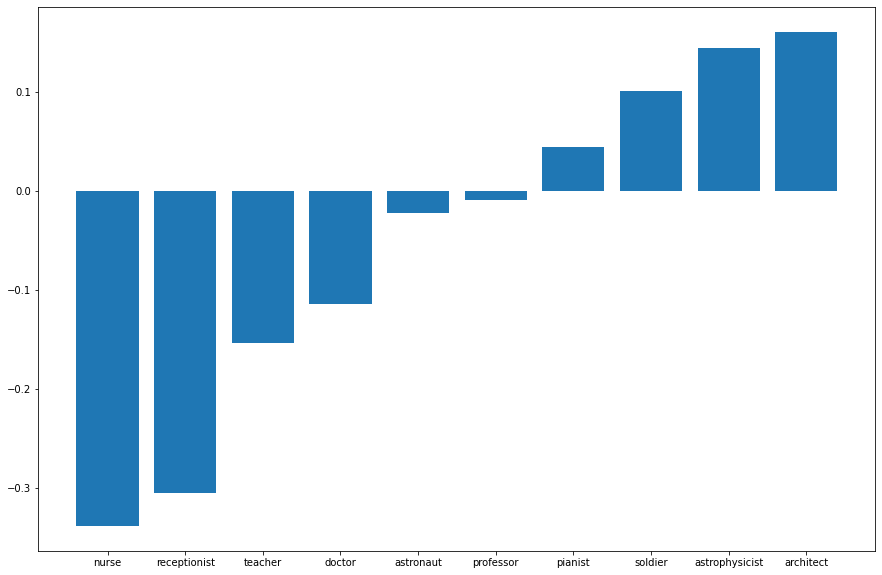

In [ ]:
# Before debiasing
words = ['doctor','architect','nurse','astronaut','astrophysicist','receptionist','soldier',\
        'professor','teacher','pianist']
print("Profession, Gender similarity")
similarity_score = []
for w in words:
    w, similarity = w, cosine_similarity(get_vector(w), g)
    similarity_score.append(similarity)

s = np.array(similarity_score)

sort_index = list(np.argsort(s))
words = [words[i] for i in sort_index]
similarity_score = [similarity_score[i] for i in sort_index]

plt.figure(figsize=(15,10))
plt.bar(list(words), list(similarity_score))

<BarContainer object of 10 artists>

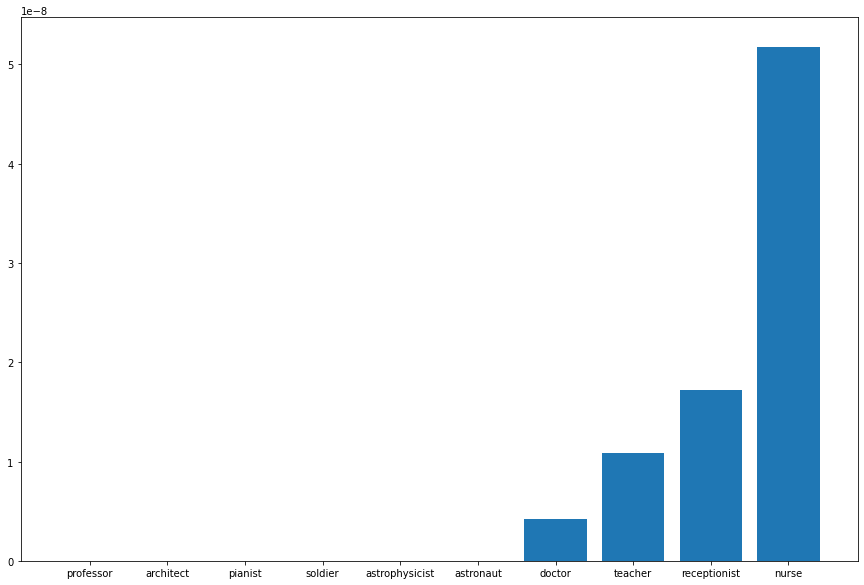

In [ ]:
# After debiasing
similarity_score = []
for w in words:
    w, similarity =w, cosine_similarity(neutralize(w,g,nlp),g)
    similarity_score.append(similarity)

s = np.array(similarity_score)

sort_index = list(np.argsort(s))
words = [words[i] for i in sort_index]
similarity_score = [similarity_score[i] for i in sort_index]

plt.figure(figsize=(15,10))
plt.bar(list(words), list(similarity_score))

Now let's repeat the experiment but for emotion related words.

Emotion, Gender similarity


<BarContainer object of 24 artists>

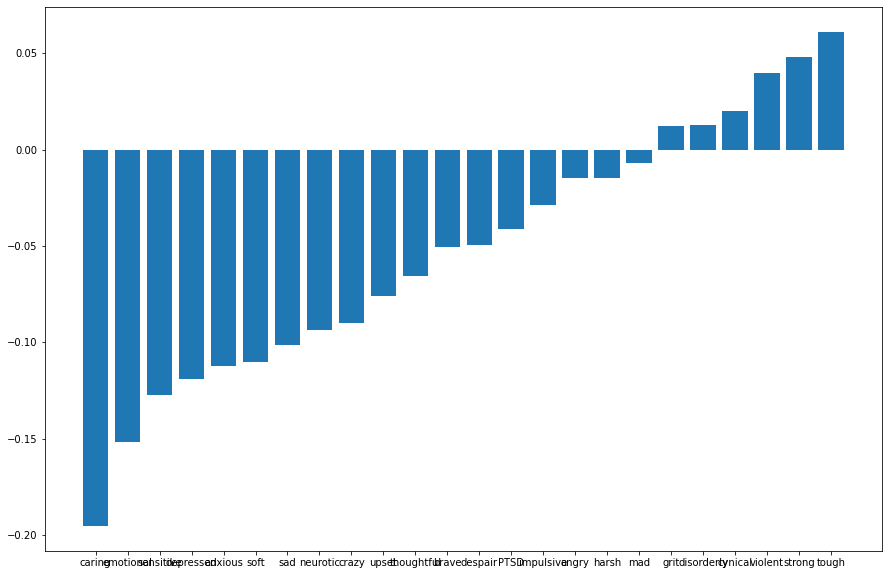

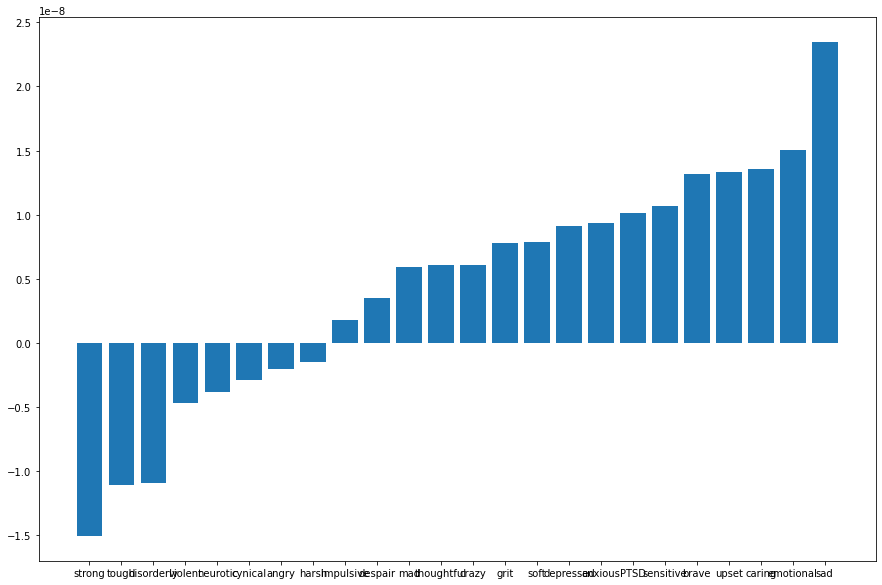

In [ ]:
## YOUR CODE HERE: repeat the experiment for emotion-related words!
# Before debiasing
words = fem_feelings+masc_feelings
print("Emotion, Gender similarity")
similarity_score = []
for w in words:
    w, similarity = w, cosine_similarity(get_vector(w), g)
    similarity_score.append(similarity)

s = np.array(similarity_score)

sort_index = list(np.argsort(s))
words = [words[i] for i in sort_index]
similarity_score = [similarity_score[i] for i in sort_index]

plt.figure(figsize=(15,10))
plt.bar(list(words), list(similarity_score))

# After debiasing
similarity_score = []
for w in words:
    w, similarity =w, cosine_similarity(neutralize(w,g,nlp),g)
    similarity_score.append(similarity)

s = np.array(similarity_score)

sort_index = list(np.argsort(s))
words = [words[i] for i in sort_index]
similarity_score = [similarity_score[i] for i in sort_index]

plt.figure(figsize=(15,10))
plt.bar(list(words), list(similarity_score))


Let's look at the plots for both jobs and emotion words after debiasing. 

             o  He-Score  She-Score Color
0        angry  0.474818   0.443001  blue
1        tough  0.410918   0.383383  blue
2   disorderly  0.231587   0.216069  blue
3       strong  0.442679   0.413016  blue
4        harsh  0.330186   0.308061  blue
5          mad  0.501047   0.467473  blue
6         PTSD -0.022983  -0.021443  blue
7      cynical  0.276482   0.257956  blue
8         grit  0.154103   0.143777  blue
9      violent  0.347510   0.324224  blue
10   sensitive  0.255709   0.238575   red
11         sad  0.479786   0.447636   red
12   depressed  0.331119   0.308932   red
13    neurotic  0.202500   0.188931   red
14       upset  0.496607   0.463330   red
15     despair  0.331977   0.309732   red
16       crazy  0.462362   0.431380   red
17   emotional  0.372109   0.347175   red
18        soft  0.312342   0.291413   red
19     anxious  0.422762   0.394433   red
               o  He-Score  She-Score Color
0        retired  0.435574   0.406387  blue
1         doctor  0.497446   0

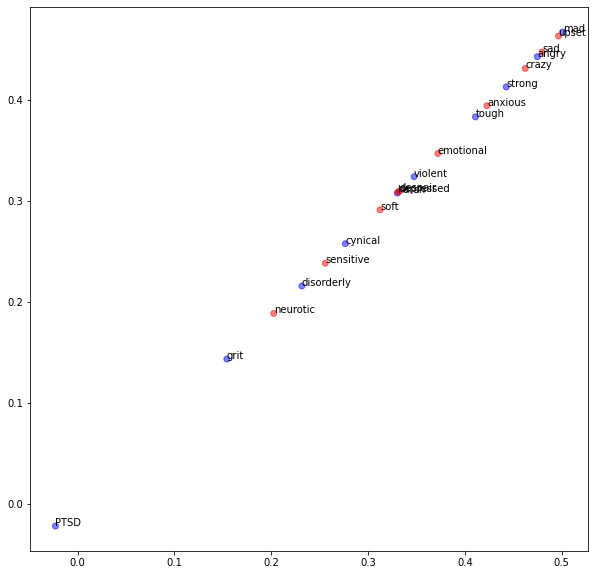

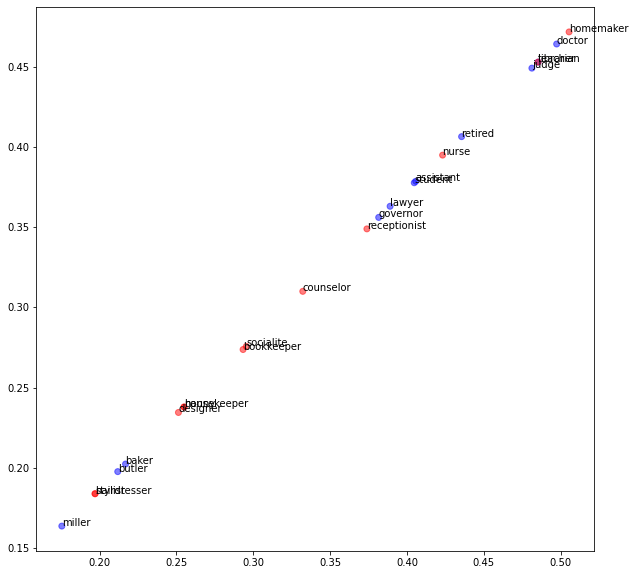

In [ ]:
male_pronoun = get_vector("he")
female_pronoun = get_vector("she")

male_jobs = ["retired", "doctor", "teacher", "student", "miller", "assistant", "lawyer", "baker", "judge", "governor", "butler"]
female_jobs = ["homemaker", "nurse", "receptionist", "librarian", "socialite", "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper", "designer", "counselor"]

df = pd.DataFrame(columns = ["o", "He-Score", "She-Score", "Color"])


male_feelings = ["angry", "tough", "disorderly", "strong", "harsh", "mad", "PTSD", "cynical", "grit", "violent"]
female_feelings = ["sensitive", "sad", "depressed", "neurotic", "upset", "despair", "crazy", "emotional", "soft", "anxious"]

for job in male_feelings:
  he_score = cosine_similarity(neutralize(job,g,nlp), male_pronoun)
  she_score = cosine_similarity(neutralize(job,g,nlp), female_pronoun)
  df = df.append(pd.Series([job, he_score, she_score, "blue"], index=df.columns), ignore_index=True)

for job in female_feelings:
  he_score = cosine_similarity(neutralize(job,g,nlp), male_pronoun)
  she_score = cosine_similarity(neutralize(job,g,nlp), female_pronoun)
  df = df.append(pd.Series([job, he_score, she_score, "red"], index=df.columns), ignore_index=True)

print(df)

plt.figure(figsize=(10,10))

plt.scatter(df['He-Score'], df['She-Score'],color=df['Color'],alpha=.5)

for word, x, y in zip(df['o'], df['He-Score'], df['She-Score']):
    plt.text(x, y, word, size = 10)

df = pd.DataFrame(columns = ["o", "He-Score", "She-Score", "Color"])

for job in male_jobs:
  he_score = cosine_similarity(neutralize(job,g,nlp), male_pronoun)
  she_score = cosine_similarity(neutralize(job,g,nlp), female_pronoun)
  df = df.append(pd.Series([job, he_score, she_score, "blue"], index=df.columns), ignore_index=True)

for job in female_jobs:
  he_score = cosine_similarity(neutralize(job,g,nlp), male_pronoun)
  she_score = cosine_similarity(neutralize(job,g,nlp), female_pronoun)
  df = df.append(pd.Series([job, he_score, she_score, "red"], index=df.columns), ignore_index=True)

print(df)

plt.figure(figsize=(10,10))

plt.scatter(df['He-Score'], df['She-Score'],color=df['Color'],alpha=.5)

for word, x, y in zip(df['o'], df['He-Score'], df['She-Score']):
    plt.text(x, y, word, size = 10)

## Using AllenNLP

Dealing with bias can be hard. The good thing is that this is a well-known problem with word embeddings, and we don't need to reinvent the wheel. We can use tools that other people have made to tackle this problem. Here's a set of tools from an organization that cares about ethical AI: Allen NLP.

First, the graphs were helpful, but we are going to look at some metrics that will help us assess the bias in our model.

### WEAT

Word Embedding Association Test (WEAT) score measures the unlikelihood there is no difference between two sets of target words in terms of their relative similarity to two sets of attribute words by computing the probability that a random permutation of attribute words would produce the observed (or greater) difference in sample means. Analog of Implicit Association Test from psychology for word embeddings.

See the docs here: https://docs.allennlp.org/main/api/fairness/bias_metrics/

```
weat_score : torch.FloatTensor
The unlikelihood there is no difference between target_embeddings1 and target_embeddings2 
in terms of their relative similarity to attribute_embeddings1 and attribute_embeddings2. 
Typical values are around [-1, 1], with values closer to 0 indicating less biased associations.
```



In [ ]:
WEAT = af.WordEmbeddingAssociationTest()
import torch
def get_weat(target1, target2, attribute1, attribute2):
  return WEAT(
      torch.tensor([nlp(word).vector for word in target1]),
      torch.tensor([nlp(word).vector for word in target2]),
      torch.tensor([nlp(word).vector for word in attribute1]),
      torch.tensor([nlp(word).vector for word in attribute2])
  )

print(get_weat(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ["woman", "queen", "princess", "witch"],
    ## YOUR CODE HERE: list a few words that are characteristic of male vocations, e.g. ["doctor"],
    ["doctor", "chef", "lawyer", "governer"],
    ## YOUR CODE HERE: list a few words that are characteristic of female vocations, e.g. ["nurse"]
    ["nurse", "cook", "housekeeper", "receptionist"]
))

print(get_weat(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ["woman", "queen", "princess", "witch"],
    mjobs,
    fjobs
))

print(get_weat(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ["woman", "queen", "princess", "witch"],
    masc_feelings,
    fem_feelings
))

tensor(1.9091)
tensor(1.8371)
tensor(1.3439)


## ECT

Embedding Coherence Test (ECT) score measures if groups of words have stereotypical associations by computing the Spearman Coefficient of lists of attribute embeddings sorted based on their similarity to target embeddings.

See the docs here: https://docs.allennlp.org/main/api/fairness/bias_metrics/

```
ect_score : torch.FloatTensor
The Spearman Coefficient measuring the similarity of lists of attribute
embeddings sorted based on their similarity to the target embeddings. Ranges
from [-1, 1], with values closer to 1 indicating less biased associations. 
```



In [ ]:
ECT = af.EmbeddingCoherenceTest()
def get_ect(target1, target2, attribute):
  return ECT(
      torch.tensor([nlp(word).vector for word in target1]),
      torch.tensor([nlp(word).vector for word in target2]),
      torch.tensor([nlp(word).vector for word in attribute])
  )

print(get_ect(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ## Note these have to be matched, i.e. man is to woman, king is to queen, etc.
    ["doctor", "banker", "nurse", "homemaker"]
))

print(get_ect(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    mjobs + fjobs
))

print(get_ect(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    masc_feelings + fem_feelings
))

tensor(0.4000)
tensor(0.5064)
tensor(0.8090)


We are also going to grab some off the shelf bias mitigators from AllenNLP--  we are going to use the Hard Bias mitigator that we coded for ourselves, and another mitigator called the Linear Bias mitigator. To find out more about how these mitigators work, visit this link, and check out other mitigators: https://guide.allennlp.org/fairness#3

In [ ]:
HBM = afb.HardBiasMitigator()
def do_hbm(eval, bias_direction, equal1, equal2):
  return HBM(
      torch.tensor([nlp(word).vector for word in eval]),
      torch.tensor(bias_direction),
      torch.tensor([nlp(word).vector for word in equal1]),
      torch.tensor([nlp(word).vector for word in equal2])
  )

LBM = afb.LinearBiasMitigator()
def do_lbm(eval, bias_direction):
  return LBM(
      torch.tensor([nlp(word).vector for word in eval]),
      torch.tensor(bias_direction)
  )

In order to do its job, the mitigator function needs to take in (1) the set of words that have bias (2) the gender "direction" that we calculated earlier (3) a set of characteristic words that identify one "pole" of gender (4) a set of characterstic words that identify the other "pole" of gender.

Let's apply our mitigator, and calculate the WEAT and ECT scores before and after, how did the scores change? Did the mitigator do its job?

In [ ]:
mitigated_embeddings = do_hbm(
    mjobs + fjobs, 
    g, 
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"]
    ["woman", "queen", "princess", "witch"]
    )

mjobs_mitigated = mitigated_embeddings[0:len(mjobs)]
fjobs_mitigated = mitigated_embeddings[len(mjobs):len(fjobs)+len(mjobs)]

print(get_weat(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ["woman", "queen", "princess", "witch"],
    mjobs,
    fjobs
))

print(WEAT(
    torch.tensor([nlp(word).vector for word in ["man", "king", "prince", "wizard"]]), ## USE THE SAME WORDS HERE AS ABOVE
    torch.tensor([nlp(word).vector for word in ["woman", "queen", "princess", "witch"]]), ## USE THE SAME WORDS HERE AS ABOVE
    mjobs_mitigated,
    fjobs_mitigated
))

print(get_ect(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ["man", "king", "prince", "wizard"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    ["woman", "queen", "princess", "witch"],
    mjobs + fjobs
))

print(ECT(
    torch.tensor([nlp(word).vector for word in ["man", "king", "prince", "wizard"]]), ## USE THE SAME WORDS HERE AS ABOVE
    torch.tensor([nlp(word).vector for word in ["woman", "queen", "princess", "witch"]]), ## USE THE SAME WORDS HERE AS ABOVE
    mitigated_embeddings[0:len(fjobs)+len(mjobs)]
))


tensor(1.8371)
tensor(0.7513)


NameError: ignored

Here we use a slighlty different mitigator, it only needs to take in (1) the set of words that have bias (2) the gender "direction" that we calculated earlier.

Let's apply our mitigator, and calculate the WEAT and ECT scores before and after, how did the scores change? Did the mitigator do its job?

In [ ]:
mitigated_embeddings = do_lbm(masc_feelings + fem_feelings, g)

masc_mitigated = mitigated_embeddings[0:len(masc_feelings)]
fem_mitigated = mitigated_embeddings[len(masc_feelings):len(fem_feelings)+len(masc_feelings)]

print(get_weat(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    masc_feelings,
    fem_feelings
))

print(WEAT(
    torch.tensor([nlp(word).vector for word in []]), ## USE THE SAME WORDS HERE AS ABOVE
    torch.tensor([nlp(word).vector for word in []]), ## USE THE SAME WORDS HERE AS ABOVE
    masc_mitigated,
    fem_mitigated
))

print(get_ect(
    ## YOUR CODE HERE: list a few words that are characteristic of male roles, e.g. ["man", "king"],
    ## YOUR CODE HERE: list a few words that are characteristic of female roles, e.g. ["woman", "queen"],
    masc_feelings + fem_feelings
))

print(ECT(
    torch.tensor([nlp(word).vector for word in []]), ## USE THE SAME WORDS HERE AS ABOVE
    torch.tensor([nlp(word).vector for word in []]), ## USE THE SAME WORDS HERE AS ABOVE
    mitigated_embeddings[0:len(masc_feelings)+len(fem_feelings)]
))


tensor(1.9435)
tensor(-1.4938)
tensor(0.8090)
tensor(0.9639)
